<hr style="border:2px solid #0281c9"> </hr>

<img align="left" alt="ESO Logo" src="http://archive.eso.org/i/esologo.png">  

<div align="center">
  <h1 style="color: #0281c9; font-weight: bold;">ESO Science Archive</h1> 
  <h2 style="color: #0281c9; font-weight: bold;">Jupyter Notebooks</h2>
</div>

<hr style="border:2px solid #0281c9"> </hr>

This notebook retrieves and analyzes astronomical observation data from the **ESO (European Southern Observatory) archive**. It queries the **TAP (Table Access Protocol) service**, processes observation times, and visualizes key parameters such as **observation timestamps, solar elevation, and sky brightness**.

## **Key Steps**
1. **Define Observatory Location**  
   - Uses **Paranal Observatory, Chile** as the observation site.  
   - Computes **Time (UCT)** when the Sun reaches **-35° below the horizon**.

2. **Query ESO TAP Service** 
   - Retrieves observational data from the `ist.alpaca` table.  
   - Filters results by **date and instrument**.

3. **Process and Clean Data** 
   - Converts timestamps to **Modified Julian Date (MJD)**.  
   - Finds the **closest observations** to the computed solar time.

4. **Visualize Observations & Solar Position**  
   - Plots **observation timestamps vs. Sun at -35°**.  
   - Plots **SQM Zenith Brightness over time**.

5. **Download & Unpack ESO FITS Files**   
   - Downloads **FITS files** from the ESO archive.  
   - Automatically **uncompresses `.Z` files** if applicable.

## **Expected Outputs**
- List of **retrieved observations** from ESO TAP service.  
- **Plots** of observation times and sky brightness.  
- Downloaded **FITS files**. 

---
**Note:** This script is designed for **ALPACA** instrument data but can be adapted for other ESO datasets. 🚀

**Note:** See `ESO_Introduction` and `ESO_Query` notebooks for more basic usage.

<hr style="border:2px solid #0281c9"> </hr>

# **Importing and basic usage of astroquery.eso**

In [1]:
import astroquery # import astroquery
print(f"astroquery version: {astroquery.__version__}") # check the version of astroquery

astroquery version: 0.4.11.dev10290


In [2]:
from astroquery.eso import Eso # import the ESO module from astroquery

In [3]:
eso = Eso() # create an instance of the ESO class 

In [4]:
eso.maxrec = 100    # For this example we limit the number of records to 3

In [5]:
# Numerical and data handling libraries
import numpy as np  # Library for numerical computations, arrays, and mathematical operations
import datetime  # Standard Python module for working with date and time objects

# Astronomical libraries
from astropy.time import Time  # Handles time conversions and formats used in astronomy
from astropy.table import vstack  # Table operations for handling structured astronomical data

# Astronomical calculations for solar elevation and observer location
from astral import Observer  # Defines an observer’s location on Earth for solar calculations
from astral.sun import time_at_elevation  # Computes the time when the Sun reaches a specific elevation

# Visualization libraries
from matplotlib import pyplot as plt  # Core plotting library for data visualization
import matplotlib.dates as mdates  # Helper for formatting date/time data on Matplotlib plots

# File handling and system interaction
import os  # Provides functions for interacting with the operating system (e.g., file paths, directory handling)
from tqdm import tqdm  # Provides a progress bar for loops, useful for tracking long-running processes

# Stop Warnings 
import warnings  # Standard Python module for issuing warnings
warnings.filterwarnings("ignore")  # Ignore all warnings, useful for cleaner output in notebooks or scripts

## **Definitions** 

In [6]:
# Output directories for data and figures
OUTPUT_DIR = "./data/"
OUTPUT_DIR_FIGS = "./figs/"

# Paranal Observatory Coordinates
LATITUDE = -24.6275
LONGITUDE = -70.4042
ELEVATION = 2635

# Set up Dates 
START_YEAR = 2024
START_MONTH = 1
START_DAY = 1
NUM_DAYS = 366

# Make output dirs if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR_FIGS, exist_ok=True)

## **Find Data** 

In [8]:
# Define observer location
observer = Observer(LATITUDE, LONGITUDE, ELEVATION)

# Define time range for 2024
dates = [datetime.date(START_YEAR, START_MONTH, START_DAY) + datetime.timedelta(days=i) for i in range(NUM_DAYS)]

# Compute time when Sun is -35 degrees below the horizon
sun_times = []
for date in dates:
    sun_time = time_at_elevation(observer, -35, date, direction="rising")
    sun_times.append(sun_time)

# Convert to MJD for TAP query
sun_times = [Time(t).isot for t in sun_times]
sun_times_mjd = Time(sun_times).mjd

# Tolerance for closest observation (in hours)
tolerance_hours = 0.1  # Adjust as needed

# Build queries for each day
query_template = """
                SELECT TOP 50 *
                FROM ist.alpaca
                WHERE instrument = 'ALPACA'
                AND date_obs BETWEEN '{start_time}' AND '{end_time}'
                ORDER BY date_obs ASC
                """

results = []

verbose = False  # Set to True for detailed output
i = -1
for date in tqdm(dates, desc="Processing dates", unit="date"):
    i += 1

    start_time = (Time(sun_times[i]) - 0.02).isot  # Start time slightly before
    end_time = (Time(sun_times[i]) + 0.02).isot  # End time slightly after
    query = query_template.format(start_time=start_time, end_time=end_time)
    
    if verbose:
        print(f"Querying for: {date} at LST {sun_times[i]}")
    result = eso.query_tap_service(query) # Query the TAP service with the ADQL query

    if result:

        # Convert date_obs column to Time format for comparison
        result_times = Time(list(result['date_obs'].data.data))
        target_time = Time(sun_times[i])
        
        # Find the closest observation
        closest_index = np.argmin(np.abs(result_times - target_time))
        closest_result = result[closest_index]
        closest_time = Time(closest_result['date_obs'])

        # Compute time difference (in hours)
        time_difference = np.abs((closest_time - target_time).to_value('hour'))

    # Check if observation is within tolerance
    if time_difference <= tolerance_hours:
        results.append(closest_result)
        if verbose: 
            print(f"Closest observations found: {closest_result['date_obs']}")
    elif time_difference > tolerance_hours:
        if verbose: 
            print(f"Closest observation outside tolerance: {closest_result['date_obs']}")
    else: 
        if verbose: 
            print(f"No observations found: {closest_result['date_obs']}")
        continue

# Stack results as astropy.table
if results:
    results = vstack(results, join_type='outer')

Processing dates: 100%|██████████| 366/366 [01:16<00:00,  4.79date/s]


## **Plot Results**

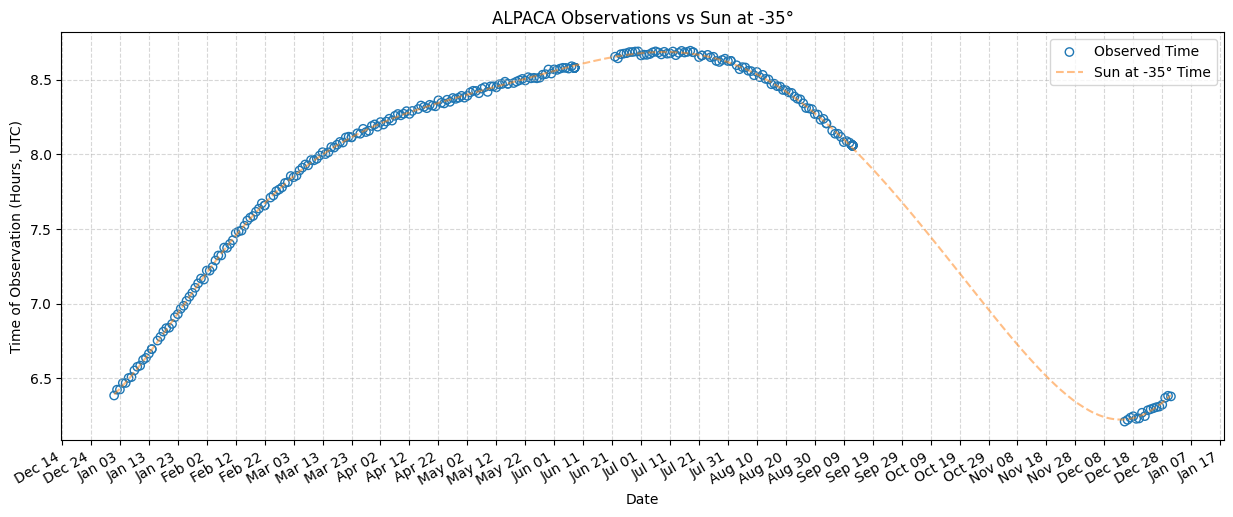

In [ ]:
times_obs = [time for time in results["date_obs"]]
times_obs_mjd = Time(times_obs).mjd

fig, ax = plt.subplots(figsize=(15, 6))

# Convert times to datetime objects
dates =     [t.datetime.date() for t in Time(times_obs_mjd, format="mjd")]
obs_times = [t.datetime for t in Time(times_obs_mjd, format="mjd")]  # Full datetime
obs_hours = [t.hour + t.minute / 60 + t.second / 3600 for t in obs_times]  # Convert to fractional hours

# Convert Sun at -35° times
sun_dates = [t.datetime.date() for t in Time(sun_times_mjd, format="mjd")]
sun_times_ = [t.datetime for t in Time(sun_times, format="isot")]
sun_hours = [t.hour + t.minute / 60 + t.second / 3600 for t in sun_times_]

# Scatter plot for observations
ax.scatter(dates, obs_hours, label="Observed Time", ec="C0", fc="none")

# Scatter plot for Sun at -35° times
# ax.scatter(sun_dates, sun_hours, label="Sun at -35° Time", color='C1', marker='x')
ax.plot(sun_dates, sun_hours, color="C1", ls="--", alpha=0.5, label="Sun at -35° Time")

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Month Day"
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Show ticks every 5 days
fig.autofmt_xdate()

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Time of Observation (Hours, UTC)")
ax.set_title("ALPACA Observations vs Sun at -35°")
ax.legend()
ax.grid(ls='--', alpha=0.5)

# Save the figure
fig.savefig(f"{OUTPUT_DIR_FIGS}/alpaca_date_obs.png", dpi=300)

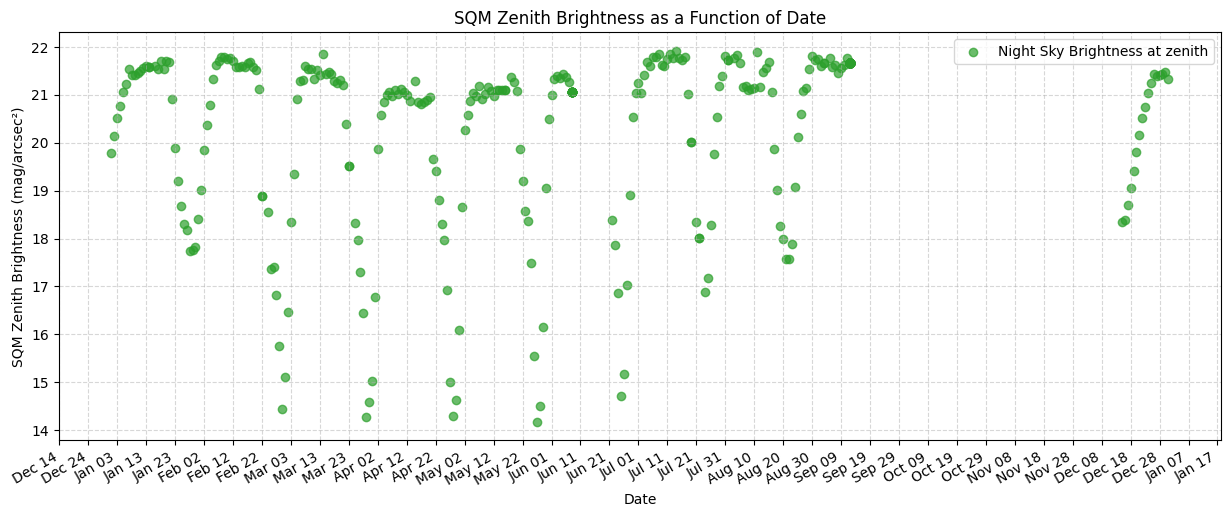

In [ ]:
# Convert date_obs to MJD
times_obs = [time for time in results["date_obs"]]
times_obs_mjd = Time(times_obs).mjd

# Convert MJD to datetime
dates = [t.datetime.date() for t in Time(times_obs_mjd, format="mjd")]

# Extract SQM Zenith values
sqm_zen_values = results["sqm_zen"]

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Scatter plot for SQM Zenith Brightness
ax.scatter(dates, sqm_zen_values, color="C2", label="Night Sky Brightness at zenith", alpha=0.7)

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
fig.autofmt_xdate()

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("SQM Zenith Brightness (mag/arcsec²)")
ax.set_title("SQM Zenith Brightness as a Function of Date")
ax.legend()
ax.grid(ls='--', alpha=0.5)

# Save the figure
fig.savefig(f"{OUTPUT_DIR_FIGS}/alpaca_sqm_zen.png", dpi=300)

## **Download Data**

In [ ]:
data_files = eso.retrieve_data(results["dp_id"][0], destination=OUTPUT_DIR) # download the first data product
data_files

INFO: Downloading datasets ... [astroquery.eso.core]
INFO: Downloading 1 files ... [astroquery.eso.core]
INFO: Downloading file 1/1 https://dataportal.eso.org/dataPortal/file/ALPACA.2024-01-01T06:23:08.420 to /Users/abarnes/Library/CloudStorage/Dropbox/GitHub/astroquery_examples/data [astroquery.eso.core]
INFO: Successfully downloaded dataset ALPACA.2024-01-01T06:23:08.420 to /Users/abarnes/Library/CloudStorage/Dropbox/GitHub/astroquery_examples/data/ALPACA.2024-01-01T06:23:08.420.fits.Z [astroquery.eso.core]
INFO: Uncompressing file /Users/abarnes/Library/CloudStorage/Dropbox/GitHub/astroquery_examples/data/ALPACA.2024-01-01T06:23:08.420.fits.Z [astroquery.eso.core]
INFO: Done! [astroquery.eso.core]


'/Users/abarnes/Library/CloudStorage/Dropbox/GitHub/astroquery_examples/data/ALPACA.2024-01-01T06:23:08.420.fits'

<hr style="border:2px solid #0281c9"> </hr>